# *Mục tiêu* :
* Xây dựng một công cụ Recommendation System sử dụng Word2vec để đề xuất các sản phẩm tương tự cho người khách hàng trên trang web thương mại điện tử dựa trên hành vi mua hàng trong quá khứ của người khách hàng.

# *Tập dữ liệu* :
*Dữ liệu của bán hàng của trang web có thể được tìm thấy ở đây [đây](https://archive.ics.uci.edu/ml/machine-learning-databases/00352/)

### Load các thư viện cần thiết

In [2]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

### Đọc dữ liệu từ file excel

In [3]:
df = pd.read_excel('Online_Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Tiền xử lý dữ liệu

In [14]:
# kiểm tra các giá trị bị thiếu
df.isnull().sum()

# loại bỏ các giá trị không hợp lệ
df.dropna(inplace=True)

#chuyển Description sang kiểu string
df['Description']= df['Description'].astype(str)

### Chia tập dữ liệu thành Train Data and Validation Data

In [60]:
customers = df['CustomerID'].unique().tolist()

# sắp xếp lại ngẫu nhiên các ID khách hàng
random.shuffle(customers)

# Chia tập dữ liệu gồm 90% train data   và 10% validation data
customers_train = [customers[i] for i in range(round(0.9*len(customers)))]

# chia dữ liệu thành train data và validation data
train_df = df[df['CustomerID'].isin(customers_train)]
validation_df = df[~df['CustomerID'].isin(customers_train)]
#print(validation_df)

### Tạo một chuỗi các sản phẩm đã mua của một khách hàng

In [61]:
#Tạo ra một list để nắm bắt lịch sử khách hàng( thực hiện trên tập train data)
purchases_train = []

# Với mỗi CustomerID sẽ ghi danh sách các sản phẩm đã mua của họ
for i in tqdm(customers_train):
    temp = train_df[train_df["CustomerID"] == i]["Description"].tolist()
    purchases_train.append(temp)

100%|█████████████████████████████████████████████████████████████████████████████| 3935/3935 [00:04<00:00, 789.62it/s]


In [62]:
# Tạo ra một list để nắm bắt lịch sử khách hàng( thực hiện trên tập validation data)
purchases_val = []
# Với mỗi CustomerID sẽ ghi danh sách các sản phẩm đã mua của họ
for i in tqdm(validation_df['CustomerID'].unique()):
    temp = validation_df[validation_df["CustomerID"] == i]["Description"].tolist()
    purchases_val.append(temp)
#import csv
#with open('file1.csv', 'w', newline='') as f:
    #writer = csv.writer(f)
    #writer.writerows(purchases_val)

100%|██████████████████████████████████████████████████████████████████████████████| 437/437 [00:00<00:00, 1168.45it/s]


### Xây dựng Word2Vec embeddings cho các sản phẩm

In [63]:
# train word2vec model
# sg= 1 (mô hình skip-gram)
# hs =0 (lấy mẫu âm) hs=1 (softmax phân cấp)
# alpha (learning rate)
# min_alpha (tốc độ mà learing rate giảm tuyến tính)
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(3529323, 3566540)

In [64]:
model.init_sims(replace=True)
print(model)
model.wv.save_word2vec_format('model.bin')
model.wv.save_word2vec_format('model.txt', binary=False)

Word2Vec(vocab=3248, size=100, alpha=0.03)


### Các thông số của mô hình sau khi đã train

In [73]:
# Model gồm 3281 từ với số chiều là 100
X = model[model.wv.vocab]

X.shape

(3248, 100)

### Visualize word2vec embeddings bằng cách thu giảm số chiều sử dụng tSNE

In [74]:
from sklearn.manifold import TSNE

In [75]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=30000, random_state=23)
    #tsne_model = TSNE(perplexity=30, n_components=2, init='pca', n_iter=250, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
    #plt.savefig('Visualize word2vec embeddings.png')

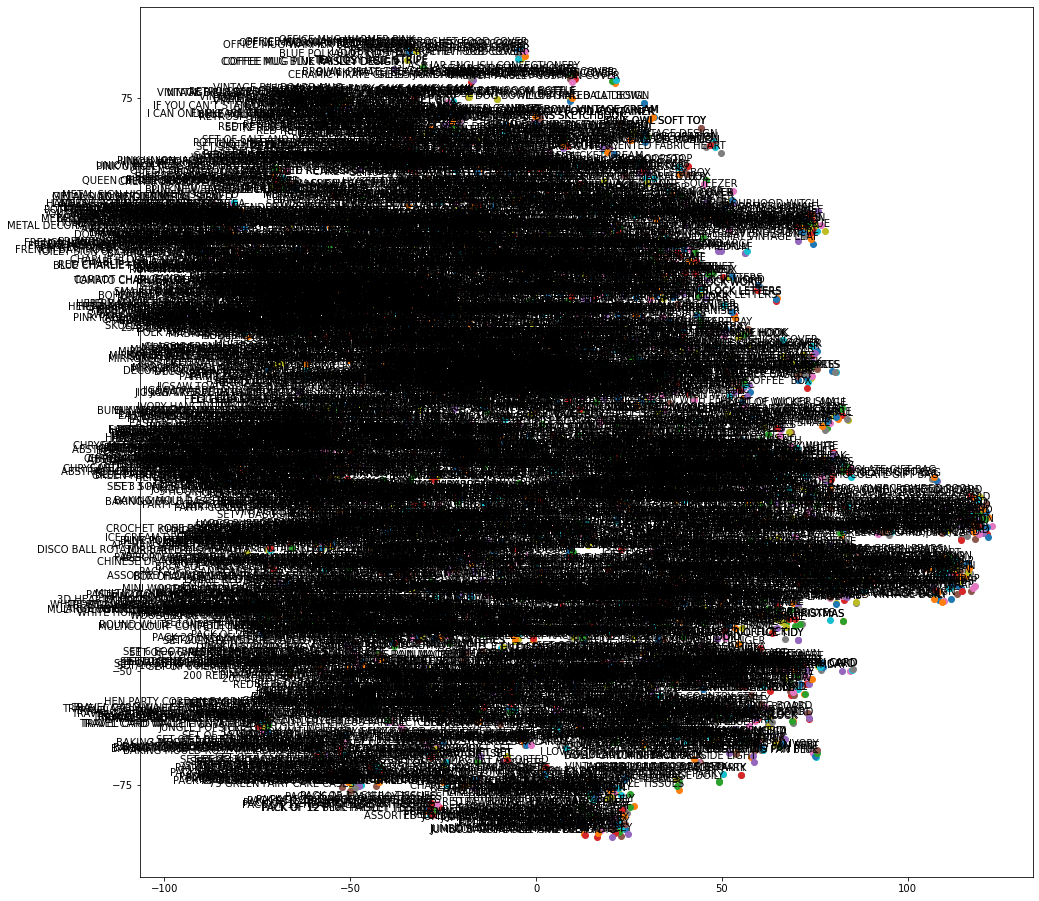

In [76]:
#Với mỗi chấm là một khách hàng và tên sản phẩm họ đã mua
tsne_plot(model)

## Đề xuất sản phẩm

### Tạo danh sách gồm mã sản phẩm- tên sản phẩm

In [81]:
products = train_df[["Description", "StockCode"]]

# loại bỏ các giá trị trùng
products.drop_duplicates(inplace=True, subset='Description', keep="last")

# ứng với mỗi sản phẩm là  mã sản phẩm và tên sản phẩm đó
products_dict = products.groupby('Description')['Description'].apply(list).to_dict()
products_dict1 = products.groupby('Description')['StockCode'].apply(list).to_dict()

### Function trả về 6 sản tương tự với một sản phẩm cho trước

In [82]:
def similar_products(v, n = 6):
    
    # extract most similar products for the input vector
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0],products_dict1[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms


### Tìm đề xuất cho một sản phẩm có tên là ("YELLOW COAT RACK PARIS FASHION")

In [83]:
similar_products(model["YELLOW COAT RACK PARIS FASHION"])

[('BLUE COAT RACK PARIS FASHION', 22914, 0.897297203540802),
 ('RED COAT RACK PARIS FASHION', 22913, 0.8819193840026855),
 ('BLUE TILED TRAY', 20793, 0.6271286606788635),
 ('FLORAL BATHROOM SET', 84847, 0.6095787882804871),
 ('METAL 4 HOOK HANGER FRENCH CHATEAU', 22173, 0.5846001505851746),
 ('HELLO SAILOR BATHROOM SET', 84842, 0.5757131576538086)]

### Function trả về giá trị trung bình của các vector sản phẩm của một khách hàng đã mua

In [84]:
def aggregate_vectors(products):
    product_vec = []
    #chuỗi các sản phẩm mà một khách hàng đã mua
    for i in products:
        try:
            product_vec.append(model[i])
        except KeyError:
            continue
      
    #tính giá trị trung bình cho product_vec
    return np.mean(product_vec, axis=0)

### Đề xuất sản phẩm dựa trên toàn bộ lịch sử mua hàng của khách hàng

In [89]:
print(validation_df['CustomerID'].unique())
#liệt kê các CustomerID (bỏ qua các giá trị trùng lắp)
#chọn ra 1 khách hàng có ID=1609
pp = validation_df[validation_df['CustomerID'] ==16098]
#liệt kê thông tin sản phẩm mà khách hàng đó đã mua
print(pp[['CustomerID', 'StockCode','Description']])
#đưa ra các đề xuất về các sản phẩm trong tương lai
similar_products(aggregate_vectors(purchases_val[0]))

[16098. 17548. 13767. 15862. 13694. 12748. 12662. 15350. 14911. 16456.
 12472. 13093. 13715. 15752. 17017. 15070. 14390. 13305. 14491. 13402.
 17961. 18225. 16891. 17787. 16455. 15708. 18156. 16983. 16327. 17026.
 16718. 17858. 17863. 16411. 15889. 16143. 12747. 12763. 16898. 14487.
 16710. 14850. 16059. 14176. 14282. 13488. 13880. 12347. 18077. 14952.
 14299. 17676. 15298. 13649. 13115. 17340. 13240. 16519. 17671. 15279.
 15380. 17442. 12731. 15179. 12753. 16927. 15159. 17041. 16262. 14871.
 13097. 17230. 17525. 12666. 15482. 16985. 17146. 17580. 14735. 15532.
 15197. 14220. 14560. 12931. 14016. 14646. 16270. 13487. 17239. 15587.
 13304. 16282. 17457. 17389. 14258. 15719. 16676. 16094. 15607. 12480.
 17095. 15611. 17128. 17800. 18171. 16279. 12393. 15569. 16791. 16554.
 13284. 18190. 14978. 12490. 12553. 14329. 18069. 15296. 12820. 16948.
 12451. 16321. 16892. 16618. 14450. 15443. 12854. 18277. 16222. 17082.
 14248. 16043. 17786. 16918. 16882. 16949. 14970. 12645. 13552. 14659.
 15365

[('ALARM CLOCK BAKELIKE IVORY', 22730, 0.786604642868042),
 ('ALARM CLOCK BAKELIKE GREEN', 22726, 0.7797957062721252),
 ('ALARM CLOCK BAKELIKE PINK', 22728, 0.7644144296646118),
 ('ALARM CLOCK BAKELIKE CHOCOLATE', 22725, 0.7413551211357117),
 ('ALARM CLOCK BAKELIKE ORANGE', 22729, 0.738258957862854),
 ('BLUE DINER WALL CLOCK', 22192, 0.7034780979156494)]

In [87]:
# Đề xuất sản phẩm dựa trên 10 sản phẩm mua gần đây nhất
print(purchases_val[0][-10:])
similar_products(aggregate_vectors(purchases_val[0][-10:]))

['ALARM CLOCK BAKELIKE IVORY', 'ALARM CLOCK BAKELIKE CHOCOLATE', 'JUMBO SHOPPER VINTAGE RED PAISLEY', 'ALARM CLOCK BAKELIKE GREEN', 'ALARM CLOCK BAKELIKE GREEN', 'VINTAGE SNAKES & LADDERS', 'BINGO SET', 'S/15 SILVER GLASS BAUBLES IN BAG', 'JINGLE BELL HEART ANTIQUE SILVER', 'JINGLE BELL HEART ANTIQUE GOLD']


[('ALARM CLOCK BAKELIKE RED ', 22727, 0.7729189395904541),
 ('ALARM CLOCK BAKELIKE IVORY', 22730, 0.7670091986656189),
 ('ALARM CLOCK BAKELIKE CHOCOLATE', 22725, 0.7611282467842102),
 ('ALARM CLOCK BAKELIKE PINK', 22728, 0.7513300180435181),
 ('ALARM CLOCK BAKELIKE ORANGE', 22729, 0.6962610483169556),
 ('IVORY DINER WALL CLOCK', 22191, 0.6312854290008545)]